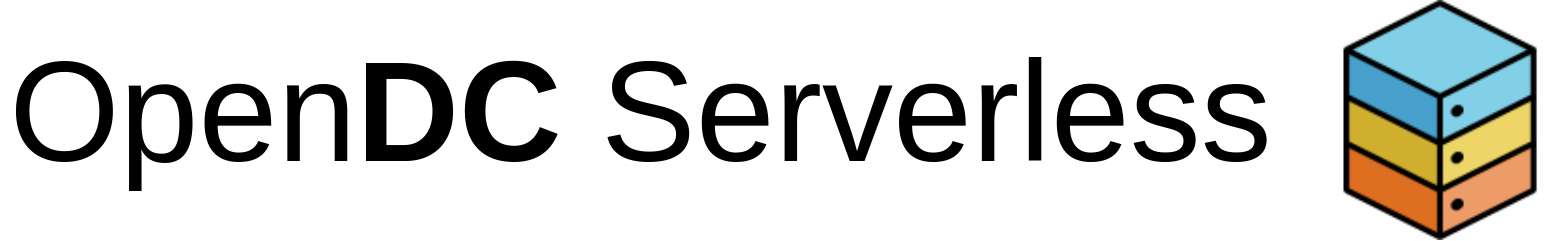
# Cold Lambda experiment results analysis
This Notebook presents a full analysis of the results of the Lambda validation experiment from the OpenDC Serverless paper 

This work accompanies the OpenDC Serverless bachelors thesis paper by Soufiane Jounaid within @Large Research

Vrije Universiteit Amsterdam 2020.

In [19]:
import string
import warnings
import re
import math
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
from matplotlib.legend import Legend
from statsmodels.distributions.empirical_distribution import ECDF

In [20]:
warnings.filterwarnings('ignore')

## Input handling (skip if processed results available)


In [7]:
lambda_path = "resources/lambda/results/lambda"

lambda_results={
    'timer': pd.read_csv(f"{lambda_path}/timer-concurrency.csv"),
    'frequent': pd.read_csv(f"{lambda_path}/frequent-concurrency.csv"),
    'infrequent': pd.read_csv(f"{lambda_path}/infrequent-concurrency.csv"),
    'veryinfrequent': pd.read_csv(f"{lambda_path}/veryinfrequent-concurrency.csv"),
    'timer_noconcurrency': pd.read_csv(f"{lambda_path}/timer-noconcurrency.csv"),
    'frequent_noconcurrency': pd.read_csv(f"{lambda_path}/frequent-noconcurrency.csv"),
    'infrequent_noconcurrency': pd.read_csv(f"{lambda_path}/infrequent-noconcurrency.csv"),
    'veryinfrequent_noconcurrency': pd.read_csv(f"{lambda_path}/veryinfrequent-noconcurrency.csv"),
}

opendc_path = "resources/lambda/results/opendc-serverless"

opendc_results = {
    'timer': pd.read_parquet(f"{opendc_path}/timer-concurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet", engine="pyarrow"),
    'frequent': pd.read_parquet(f"{opendc_path}/frequent-concurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-840000msTimeout-18VM's.parquet", engine="pyarrow"),
    'infrequent': pd.read_parquet(f"{opendc_path}/infrequent-concurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1740000msTimeout-18VM's.parquet", engine="pyarrow"),
    'veryinfrequent': pd.read_parquet(f"{opendc_path}/veryinfrequent-concurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet", engine="pyarrow"),
    'timer_noconcurrency': pd.read_parquet(f"{opendc_path}/timer-noconcurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet", engine="pyarrow"),
    'frequent_noconcurrency': pd.read_parquet(f"{opendc_path}/frequent-noconcurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-300000msTimeout-18VM's.parquet", engine="pyarrow"),
    'infrequent_noconcurrency': pd.read_parquet(f"{opendc_path}/infrequent-noconcurrency/randomAlloc-randomRouting-hybrid-histogramResourceManagement-14400000msLimit-18VM's.parquet", engine="pyarrow"),
    'veryinfrequent_noconcurrency': pd.read_parquet(f"{opendc_path}/veryinfrequent-noconcurrency/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet", engine="pyarrow")}


# Pre processing (skip if done once)

## Matching the timestamp format between both results

In [4]:
for key in lambda_results.keys():
    lambda_results.update({f'{key}': lambda_results.get(key).rename(columns={
                           'bin(1s)': 'Datetime',
                           'avg(@timestamp)': 'Time',
                           'avg(@duration)': 'ExecutionTime',
                           'avg(@initDuration)': 'ColdStarts',
                           'avg(@maxMemoryUsed /1024 / 1024)': 'MemoryUsage'})})
    lambda_results.get(key)['Time'] = lambda_results.get(key)['Time'].astype(int)
    lambda_results.get(key).loc[lambda_results.get(key)['ColdStarts'] > 0, 'ColdStarts'] = 1
    lambda_results.get(key).drop(lambda_results.get(key).columns.difference(['Time','ColdStarts']), 1, inplace=True)

In [5]:
for key in list(opendc_results):
    opendc_results.get(key)['Time'] = (1596255027000 + opendc_results.get(key)['Time']).astype(int)
    opendc_results.update({f'{key}': opendc_results.get(key)[opendc_results.get(key)['Invocations'] > 0].reset_index(drop=True)})

    working_list = opendc_results.get(key).loc[opendc_results.get(key)['Invocations'] > 1]

    for row in working_list.iterrows():
        for i in range(row[1].Invocations -1):
            opendc_results.update({f'{key}': 
                                   opendc_results.get(key).append(row[1])
                                   .sort_values('Time', axis=0)
                                   .assign(Invocations=1)
                                   .reset_index(drop=True)})
            opendc_results.get(key).loc[opendc_results.get(key)['ColdStarts'] > 0, 'ColdStarts'] = 1
            
    opendc_results.get(key).loc[opendc_results.get(key)['ColdStarts'] > 0, 'ColdStarts'] = 1
    opendc_results.get(key).drop(opendc_results.get(key).columns.difference(['Time','ColdStarts']), 1, inplace=True)


In [6]:
for key in opendc_results.keys():
    dates = []
    for i in opendc_results.get(key)['Time']:
        dates.append(datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d %H:%M:%S'))
    opendc_results.get(key).insert(0, 'Datetime', dates)

for key in lambda_results.keys():
    dates = []
    for i in lambda_results.get(key)['Time']:
        dates.append(datetime.datetime.fromtimestamp(i/1000))
    lambda_results.get(key).insert(0, 'Datetime', dates)

## Quick Fix for Loss of data due to internet loss: 

During the experiment, internet was cutoff betweem the invoker and the AWS API at August-1-20 14:17:16, the missing requests are thus removed here

Missing indices:

* frequent= 29,38,213, 183, 278
* frequent_noconcurrency = 182
* infrequent = 44, 100, 101, 102, 103, 104 
* infrequent_noconcurrency = 60

In [7]:
opendc_results['frequent'].drop([29,38,213,183,278], axis=0, inplace=True)
opendc_results['frequent'].reset_index(drop=True, inplace=True)
opendc_results['frequent_noconcurrency'].drop(182, axis=0, inplace=True)
opendc_results['frequent_noconcurrency'].reset_index(drop=True, inplace=True)
opendc_results['infrequent'].drop([44,100,101,102,103,104], axis=0, inplace=True)
opendc_results['infrequent'].reset_index(drop=True, inplace=True)
opendc_results['infrequent_noconcurrency'].drop(60, axis=0, inplace=True)
opendc_results['infrequent_noconcurrency'].reset_index(drop=True, inplace=True)

In [8]:
for key in opendc_results.keys():
    opendc_results.get(key)['Datetime'] = lambda_results.get(key)['Datetime']

In [11]:
for key in lambda_results.keys():
    lambda_results.get(key).to_csv(f"resources/lambda/results/processed-results/lambda_{key}.csv", index=False)
    opendc_results.get(key).to_csv(f"resources/lambda/results/processed-results/opendc_{key}.csv", index=False)

## Processed results (if available)

In [36]:
path = "resources/lambda/results/processed-results"

lambda_procresults={
    'timer': pd.read_csv(f"{path}/lambda_timer.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'frequent': pd.read_csv(f"{path}/lambda_frequent.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'infrequent': pd.read_csv(f"{path}/lambda_infrequent.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'veryinfrequent': pd.read_csv(f"{path}/lambda_veryinfrequent.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'timer_noconcurrency': pd.read_csv(f"{path}/lambda_timer_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'frequent_noconcurrency': pd.read_csv(f"{path}/lambda_frequent_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'infrequent_noconcurrency': pd.read_csv(f"{path}/lambda_infrequent_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'veryinfrequent_noconcurrency': pd.read_csv(f"{path}/lambda_veryinfrequent_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
}

opendc_procresults={
    'timer': pd.read_csv(f"{path}/opendc_timer.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'frequent': pd.read_csv(f"{path}/opendc_frequent.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'infrequent': pd.read_csv(f"{path}/opendc_infrequent.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'veryinfrequent': pd.read_csv(f"{path}/opendc_veryinfrequent.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'timer_noconcurrency': pd.read_csv(f"{path}/opendc_timer_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'frequent_noconcurrency': pd.read_csv(f"{path}/opendc_frequent_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'infrequent_noconcurrency': pd.read_csv(f"{path}/opendc_infrequent_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'infrequent_noconcurrency_hybrid': pd.read_csv(f"{path}/opendc_infrequent_noconcurrency_hybrid.csv", parse_dates=['Datetime'], index_col=['Datetime']),
    'veryinfrequent_noconcurrency': pd.read_csv(f"{path}/opendc_veryinfrequent_noconcurrency.csv", parse_dates=['Datetime'], index_col=['Datetime']),
}


# OpenDC vs Lambda Coldstart variation

In [3]:
sns.set()
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

## Comparative Cold Start event plots

### Timer Invocation Pattern

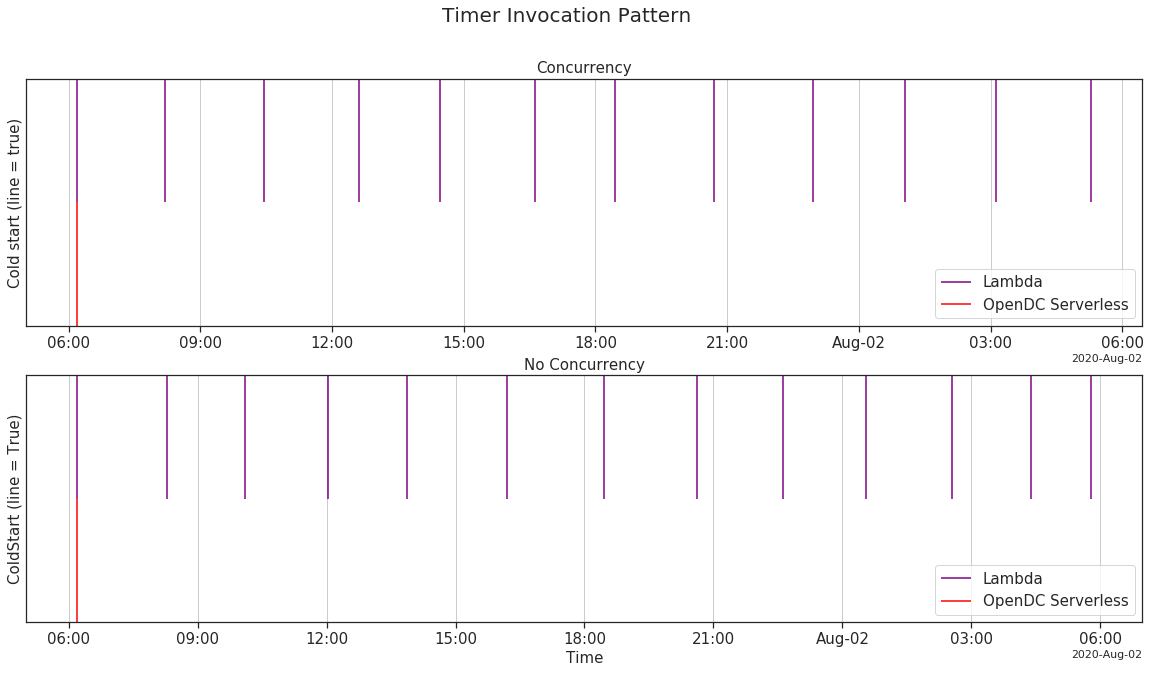

In [22]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2,1, figsize= (20,10))

    fig.suptitle("Timer Invocation Pattern", fontsize=20)

    ax[0].set_ylim(-0.5,1.5)
    ax[1].set_ylim(-0.5,1.5)

    ax[0].set_title("Concurrency", fontsize=15)
    ax[1].set_title("No Concurrency", fontsize=15)

    ax[0].set_yticks([])
    ax[0].set_ylabel('Cold start (line = true)', fontsize=15)
    
    ax[1].set_yticks([])
    ax[1].set_ylabel('ColdStart (line = True)', fontsize=15)
    ax[1].set_xlabel('Time', fontsize=15)

    plot1 = ax[0].eventplot(lambda_procresults['timer'][lambda_procresults['timer']['ColdStarts'] > 0].index, color='purple')
    plot2 = ax[0].eventplot(opendc_procresults['timer'][opendc_procresults['timer']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    plot3 = ax[1].eventplot(lambda_procresults['timer_noconcurrency'][lambda_procresults['timer_noconcurrency']['ColdStarts'] > 0].index, color='purple')
    plot4 = ax[1].eventplot(opendc_procresults['timer_noconcurrency'][opendc_procresults['timer_noconcurrency']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    ax[0].legend([plot1,plot2], labels =['Lambda','OpenDC Serverless'], fontsize=15, loc="lower right")    
    ax[1].legend([plot3,plot4], labels =['Lambda','OpenDC Serverless'], fontsize=15, loc="lower right") 
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)
    

### Frequent Invocation Pattern

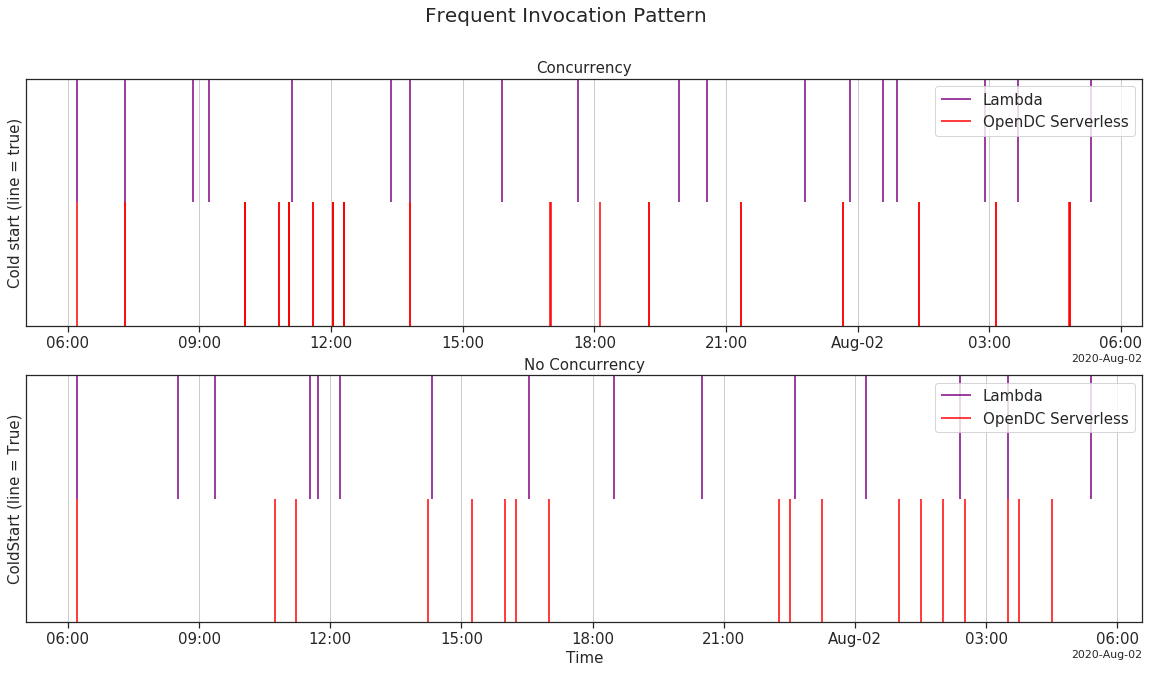

In [25]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2, 1, figsize= (20,10))

    fig.suptitle("Frequent Invocation Pattern", fontsize= 20)

    ax[0].set_ylim(-0.5,1.5)
    ax[1].set_ylim(-0.5,1.5)

    ax[0].set_title("Concurrency", fontsize=15)
    ax[1].set_title("No Concurrency", fontsize=15)

    ax[0].set_yticks([])
    ax[0].set_ylabel('Cold start (line = true)', fontsize=15)
    
    ax[1].set_yticks([])
    ax[1].set_ylabel('ColdStart (line = True)', fontsize=15)
    ax[1].set_xlabel('Time', fontsize=15)

    plot1 = ax[0].eventplot(lambda_procresults['frequent'][lambda_procresults['frequent']['ColdStarts'] > 0].index, color='purple')
    plot2 = ax[0].eventplot(opendc_procresults['frequent'][opendc_procresults['frequent']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    plot3 = ax[1].eventplot(lambda_procresults['frequent_noconcurrency'][lambda_procresults['frequent_noconcurrency']['ColdStarts'] > 0].index, color='purple')
    plot4 = ax[1].eventplot(opendc_procresults['frequent_noconcurrency'][opendc_procresults['frequent_noconcurrency']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    ax[0].legend([plot1,plot2], labels =['Lambda','OpenDC Serverless'], fontsize=15)    
    ax[1].legend([plot3,plot4], labels =['Lambda','OpenDC Serverless'], fontsize=15) 
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

### Infrequent Invocation Pattern

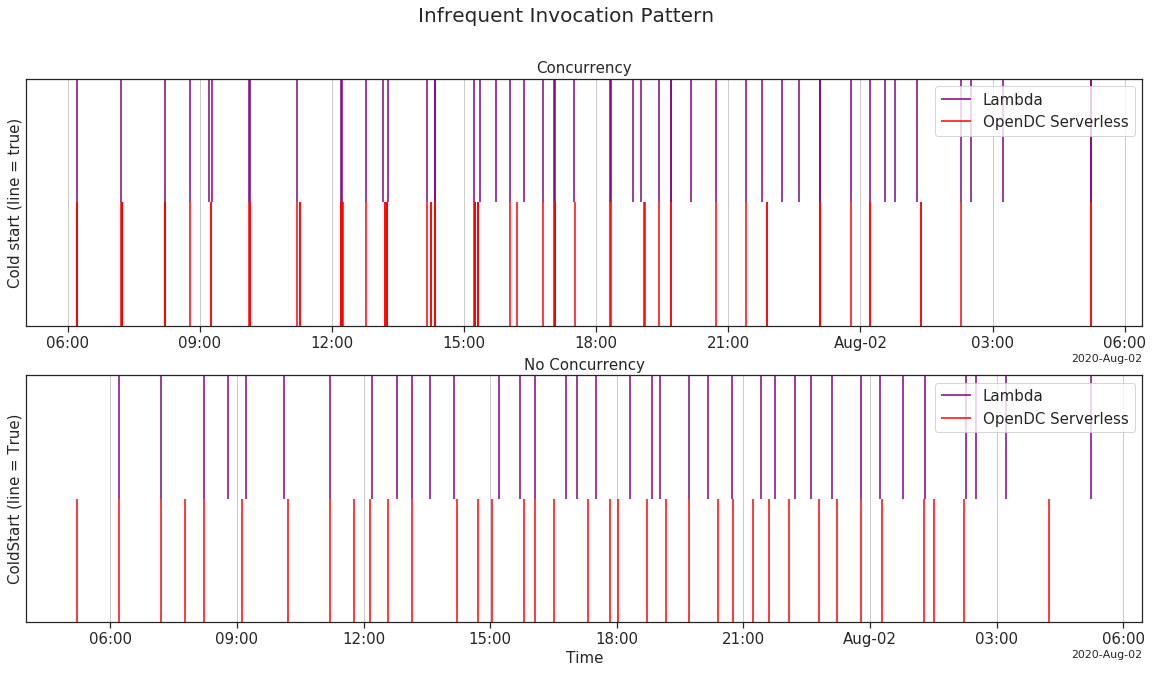

In [34]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2, 1, figsize= (20,10))

    fig.suptitle("Infrequent Invocation Pattern", fontsize= 20)

    ax[0].set_ylim(-0.5,1.5)
    ax[1].set_ylim(-0.5,1.5)

    ax[0].set_title("Concurrency", fontsize=15)
    ax[1].set_title("No Concurrency", fontsize=15)

    ax[0].set_yticks([])
    ax[0].set_ylabel('Cold start (line = true)', fontsize=15)
    
    ax[1].set_yticks([])
    ax[1].set_ylabel('ColdStart (line = True)', fontsize=15)
    ax[1].set_xlabel('Time', fontsize=15)

    plot1 = ax[0].eventplot(lambda_procresults['infrequent'][lambda_procresults['infrequent']['ColdStarts'] > 0].index, color='purple')
    plot2 = ax[0].eventplot(opendc_procresults['infrequent'][opendc_procresults['infrequent']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    plot3 = ax[1].eventplot(lambda_procresults['infrequent_noconcurrency'][lambda_procresults['infrequent_noconcurrency']['ColdStarts'] > 0].index, color='purple')
    plot4 = ax[1].eventplot(opendc_procresults['infrequent_noconcurrency'][opendc_procresults['infrequent_noconcurrency']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    ax[0].legend([plot1,plot2], labels =['Lambda','OpenDC Serverless'], fontsize=15)    
    ax[1].legend([plot3,plot4], labels =['Lambda','OpenDC Serverless'], fontsize=15) 
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

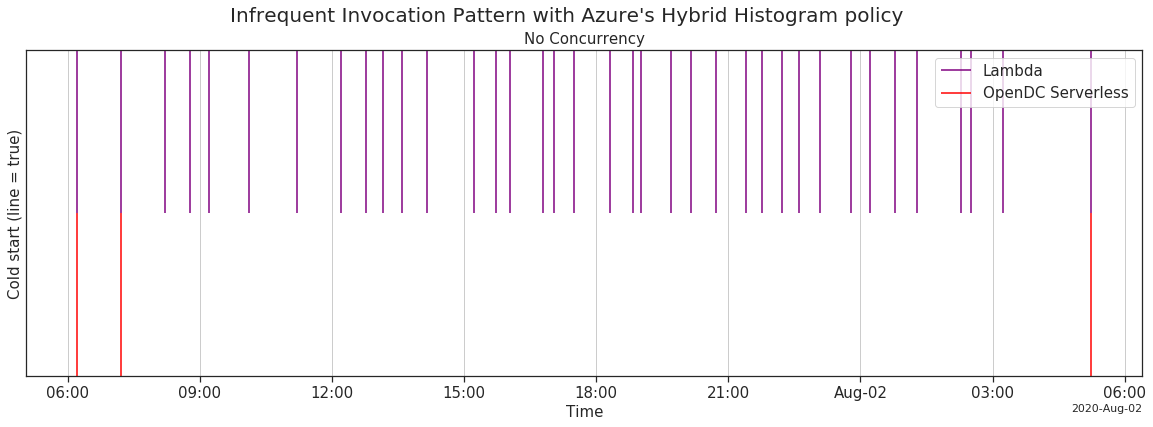

In [46]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(1, figsize= (20,6))

    fig.suptitle("Infrequent Invocation Pattern with Azure's Hybrid Histogram policy", fontsize=20)

    ax.set_ylim(-0.5,1.5)
    
    ax.set_title("No Concurrency", fontsize=15)
    
    ax.set_yticks([])
    ax.set_ylabel('Cold start (line = true)', fontsize=15)
    ax.set_xlabel('Time', fontsize=15)

    plot1 = ax.eventplot(lambda_procresults['infrequent_noconcurrency'][lambda_procresults['infrequent_noconcurrency']['ColdStarts'] > 0].index, color='purple')
    plot2 = ax.eventplot(opendc_procresults['infrequent_noconcurrency_hybrid'][opendc_procresults['infrequent_noconcurrency_hybrid']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    ax.legend([plot1,plot2], labels =['Lambda','OpenDC Serverless'], fontsize=15)    
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

### Very Infrequent Invocation Pattern

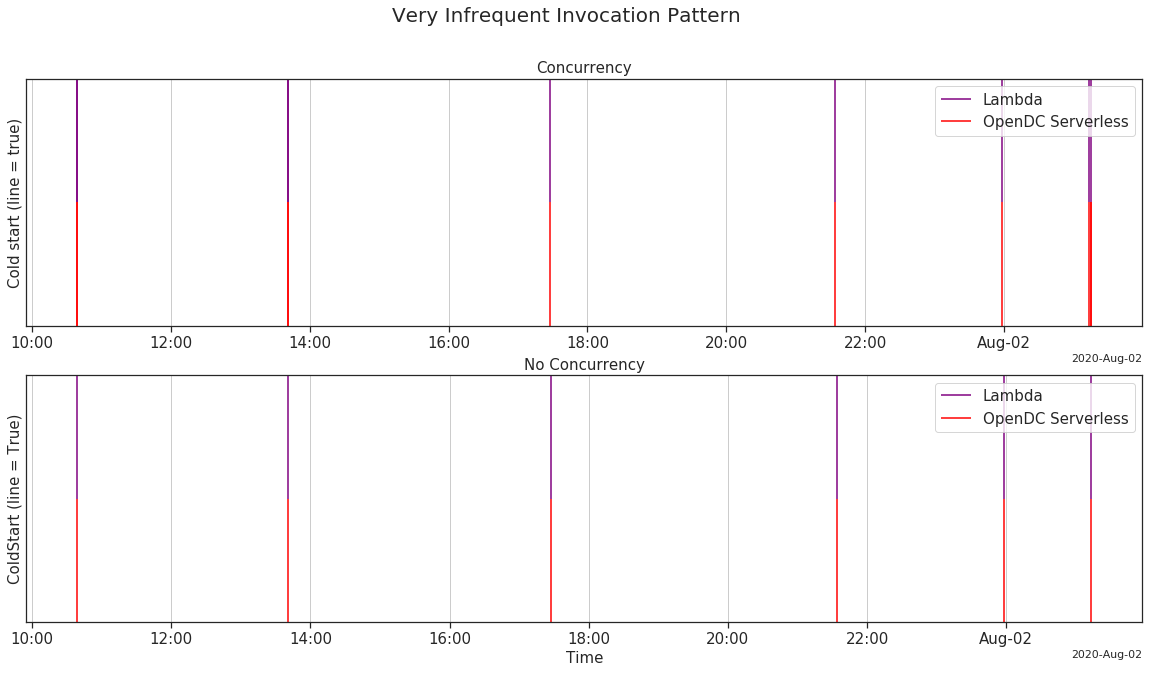

In [32]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2, 1, figsize= (20,10))

    fig.suptitle("Very Infrequent Invocation Pattern", fontsize= 20)

    ax[0].set_ylim(-0.5,1.5)
    ax[1].set_ylim(-0.5,1.5)

    ax[0].set_title("Concurrency", fontsize=15)
    ax[1].set_title("No Concurrency", fontsize=15)

    ax[0].set_yticks([])
    ax[0].set_ylabel('Cold start (line = true)', fontsize=15)
    
    ax[1].set_yticks([])
    ax[1].set_ylabel('ColdStart (line = True)', fontsize=15)
    ax[1].set_xlabel('Time', fontsize=15)

    plot1 = ax[0].eventplot(lambda_procresults['veryinfrequent'][lambda_procresults['veryinfrequent']['ColdStarts'] > 0].index, color='purple')
    plot2 = ax[0].eventplot(opendc_procresults['veryinfrequent'][opendc_procresults['veryinfrequent']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    plot3 = ax[1].eventplot(lambda_procresults['veryinfrequent_noconcurrency'][lambda_procresults['veryinfrequent_noconcurrency']['ColdStarts'] > 0].index, color='purple')
    plot4 = ax[1].eventplot(opendc_procresults['veryinfrequent_noconcurrency'][opendc_procresults['veryinfrequent_noconcurrency']['ColdStarts'] > 0].index, lineoffsets=0, color='red')

    ax[0].legend([plot1,plot2], labels =['Lambda','OpenDC Serverless'], fontsize=15)    
    ax[1].legend([plot3,plot4], labels =['Lambda','OpenDC Serverless'], fontsize=15) 
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)
